In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from joblib import dump,load

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay,accuracy_score,classification_report, RocCurveDisplay

In [31]:
OUTPUT_DIR = "../outputs/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)
SUBMISSION_DIR = os.path.join(OUTPUT_DIR, "submissions")
os.makedirs(SUBMISSION_DIR, exist_ok=True)

In [32]:
PROCESSED_DATA_DIR = "../data/processed/"

train_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"train_processed.csv"))
train_df = train_df.drop(columns=["PassengerId"])
test_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,"test_processed.csv"))
passenger_ids = test_df["PassengerId"]
test_df = test_df.drop(columns=["PassengerId","Survived"])

In [33]:
X = train_df.drop(columns=["Survived"])
y = train_df["Survived"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [34]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, eval_metric='logloss'),
}

try:
    for name, model in models.items():
        loaded_model = load(os.path.join(MODEL_DIR,f"{name.replace(' ', '_')}.joblib"))
        models[name] = loaded_model
        print(f"Loaded model for {name}")
except FileNotFoundError:
    for name, model in models.items():
        model.fit(X_train, y_train)

Loaded model for Logistic Regression
Loaded model for Random Forest
Loaded model for XGBoost


In [35]:

for name, model in models.items():
    preds = model.predict(X_val)
    if preds.dtype.kind != 'i':  # i = integer
        preds = (preds > 0.5).astype(int)
    # print(f'preds = {preds}')
    print(f"{name} Accuracy: {accuracy_score(y_val, preds):.4f}")


Logistic Regression Accuracy: 0.8324
Random Forest Accuracy: 0.7989
XGBoost Accuracy: 0.7765


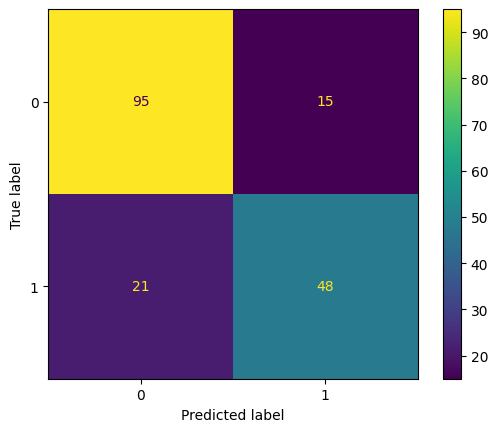

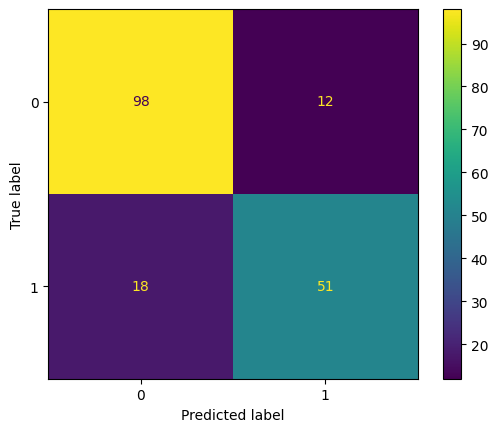

In [36]:
ConfusionMatrixDisplay.from_estimator(models["Random Forest"], X_val, y_val)
ConfusionMatrixDisplay.from_estimator(models["Logistic Regression"], X_val, y_val)

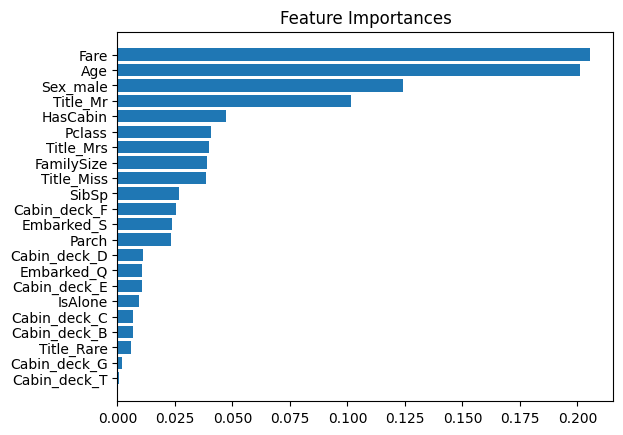

In [37]:
importances = models["Random Forest"].feature_importances_
indices = np.argsort(importances)[::-1]
plt.barh(X.columns[indices], importances[indices])
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.show()


In [38]:
# Convert to Python sets for easy comparison
X_test = test_df
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

# Columns present in X_train but missing in X_test (Misalignment 1)
missing_in_test = train_cols.difference(test_cols)
print(f"Columns missing in X_test: {missing_in_test}")

# Columns present in X_test but NOT in X_train (Misalignment 2 - usually dropped by reindex)
extra_in_test = test_cols.difference(train_cols)
print(f"Columns extra in X_test: {extra_in_test}")
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

Columns missing in X_test: set()
Columns extra in X_test: set()


In [39]:
# Dictionary to store predictions
test_preds = {}

for name, model in models.items():
    preds = model.predict(X_test)
    # If model outputs floats (XGBRegressor, etc.), threshold at 0.5
    if preds.dtype.kind != 'i':  
        preds = (preds > 0.5).astype(int)
    test_preds[name] = preds

    # Save model if not already saved
    if not os.path.exists(os.path.join(MODEL_DIR, f"{name.replace(' ', '_')}.joblib")):
        dump(model, os.path.join(MODEL_DIR, f"{name.replace(' ', '_')}.joblib"))
        print(f"Saved model for {name}")

    # Save submission CSV
    submission_df = pd.DataFrame({
        "PassengerId": passenger_ids,
        "Survived": preds
    })
    submission_df.to_csv(
        os.path.join(SUBMISSION_DIR, f"submission_{name.replace(' ', '_')}.csv"),
        index=False
    )
    print(f"{name} submission saved!")

Logistic Regression submission saved!
Random Forest submission saved!
XGBoost submission saved!


# Fine and tunning  (im jsut going to check if it)
https://www.geeksforgeeks.org/machine-learning/how-to-optimize-logistic-regression-performance/#understanding-logistic-regression


In [40]:
# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],  
    'penalty': ['l2']  # keep it simple for now
}

# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    # 'colsample_bytree': [0.7, 0.8, 1.0]
}


In [41]:
try:
    for name, model in models.items():
        loaded_model = load(os.path.join(MODEL_DIR,f"after_fine_tune_{name.replace(' ', '_')}.joblib"))
        models[name] = loaded_model
        print(f"Loaded fine-tuned model for {name}")

except FileNotFoundError:
    print("Model file not found. Proceeding with hyperparameter tuning.")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=cv, scoring='accuracy')
    grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=cv, scoring='accuracy')
    grid_xgb = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss', random_state=42), param_grid_xgb, cv=cv, scoring='accuracy')

    print("Tuning Logistic Regression...")
    grid_lr.fit(X_train, y_train)
    print("Best LR Params:", grid_lr.best_params_)
    print("Best LR CV Accuracy:", grid_lr.best_score_)


    print("Tuning Random Forest...")
    grid_rf.fit(X_train, y_train)
    print("Best RF Params:", grid_rf.best_params_)
    print("Best RF CV Accuracy:", grid_rf.best_score_)


    print("Tuning XGBoost...")
    grid_xgb.fit(X_train, y_train)
    print("Best XGB Params:", grid_xgb.best_params_)
    print("Best XGB CV Accuracy:", grid_xgb.best_score_)

    models = {
        "Logistic Regression": grid_lr.best_estimator_,
        "Random Forest": grid_rf.best_estimator_,
        "XGBoost": grid_xgb.best_estimator_,
    }


Loaded fine-tuned model for Logistic Regression
Loaded fine-tuned model for Random Forest
Loaded fine-tuned model for XGBoost


In [42]:
for name, model in models.items():
    model.fit(X_train, y_train)

for name, model in models.items():
    preds = model.predict(X_val)
    if preds.dtype.kind != 'i':  # i = integer
        preds = (preds > 0.5).astype(int)
    # print(f'preds = {preds}')
    print(f"{name} Accuracy: {accuracy_score(y_val, preds):.4f}")

Logistic Regression Accuracy: 0.8492
Random Forest Accuracy: 0.8101
XGBoost Accuracy: 0.8101


In [43]:
after_fine_tune_test_preds = {}
for name, model in models.items():
    preds = model.predict(X_test)
    # If model outputs floats (XGBRegressor, etc.), threshold at 0.5
    if preds.dtype.kind != 'i':  
        preds = (preds > 0.5).astype(int)
    after_fine_tune_test_preds[name] = preds

    # Save model if not already saved
    if not os.path.exists(os.path.join(MODEL_DIR, f"after_fine_tune_{name.replace(' ', '_')}.joblib")):
        dump(model, os.path.join(MODEL_DIR, f"after_fine_tune_{name.replace(' ', '_')}.joblib"))
        print(f"Saved fine-tuned model for {name}")

    # Save submission CSV
    submission_df = pd.DataFrame({
        "PassengerId": passenger_ids,
        "Survived": preds
    })
    submission_df.to_csv(
        os.path.join(SUBMISSION_DIR, f"after_fine_tune_submission_{name.replace(' ', '_')}.csv"),
        index=False
    )
    print(f"after_fine_tune_{name} submission saved!")

after_fine_tune_Logistic Regression submission saved!
after_fine_tune_Random Forest submission saved!
after_fine_tune_XGBoost submission saved!


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       110
           1       0.82      0.78      0.80        69

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179



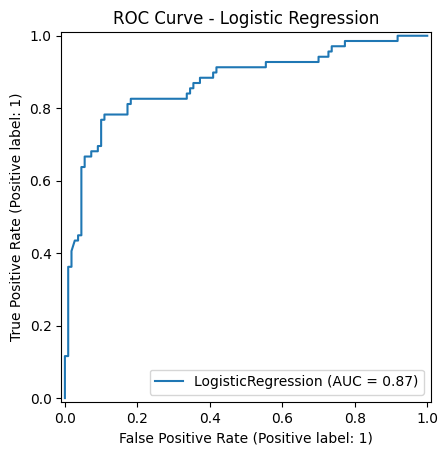

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       110
           1       0.81      0.67      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.81      0.81       179



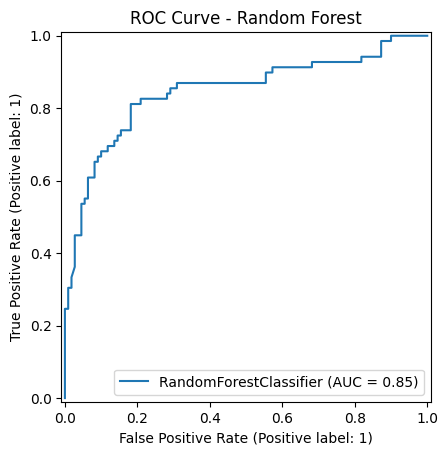

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       110
           1       0.79      0.70      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



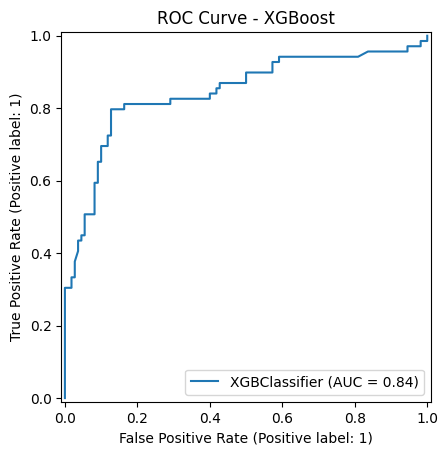

In [44]:
for name, model in models.items():
    preds = model.predict(X_val)
    print(f"=== {name} ===")
    print(classification_report(y_val, preds))
    RocCurveDisplay.from_estimator(model, X_val, y_val)
    plt.title(f"ROC Curve - {name}")
    plt.show()